In [3]:
from urllib import urlretrieve

ImportError: cannot import name 'urlretrieve'

In [10]:
from urllib import urlretrieve

ImportError: cannot import name 'urlretrieve'

In [1]:
from urllib.request import urlretrieve

In [2]:
from os.path import isfile, isdir

In [3]:
from tqdm import tqdm

In [6]:
import problem_unittests as tests

In [5]:
import problem_unittests as tests

In [8]:
import tarfile

In [9]:
import helper

In [10]:
import numpy as np

In [11]:
from sklearn import preprocessing

In [12]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'

In [13]:
import psutil

In [14]:
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!



Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


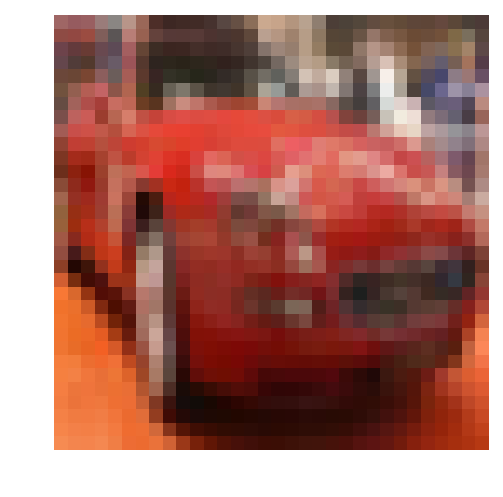

Press [enter] to continue.


In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [16]:
def normalize(x):
    w = 0
    pixels = np.ndarray((len(x), 32, 32, 3))
    for p in x:
        p = p.flatten()
        p = abs((p - 128.) / 128.)
        p = p.reshape(1, 32, 32, 3)
        pixels[w, :, :, :] = p
        w += 1
    return pixels


tests.test_normalize(normalize)

Normalization Tests Passed.


In [17]:
def one_hot_encode(x):
    classes = list(range(10))
    lb = preprocessing.LabelBinarizer()
    lb.fit(classes)
    return lb.transform(x)
   
    
tests.test_one_hot_encode(one_hot_encode)

One-Hot-Encode Tests Passed.


In [19]:
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [20]:
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [21]:
import tensorflow as tf

# Build each neural network layer into a function.
# INPUT LAYER:

def neural_net_image_input(image_shape):
    return tf.placeholder(tf.float32, shape=(None, image_shape[0], image_shape[1], image_shape[2]), name='x')


def neural_net_label_input(n_classes):
    return tf.placeholder(tf.float32, shape=(None, n_classes), name='y')


def neural_net_keep_prob_input():
    return tf.placeholder(tf.float32, name='keep_prob') 


tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


In [22]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    weight = tf.Variable(
                 tf.truncated_normal(
                     shape=[conv_ksize[0], conv_ksize[1], x_tensor.get_shape().as_list()[3], conv_num_outputs],
                     mean=0.0,
                     stddev=0.1))
    bias = tf.Variable(tf.zeros(shape=conv_num_outputs))
    
    conv = tf.nn.conv2d(x_tensor, weight, strides=[1, conv_strides[0], conv_strides[1], 1], padding='SAME')
    hidden = tf.nn.relu(conv + bias)
    pool = tf.nn.max_pool(hidden,
                         ksize=[1, pool_ksize[0], pool_ksize[1], 1],
                         strides=[1, pool_strides[0], pool_strides[1], 1],
                         padding='SAME')
    return pool


tests.test_con_pool(conv2d_maxpool)

Convolution Layer Test Passed.


In [23]:
def flatten(x_tensor):
    shaped = x_tensor.get_shape().as_list()
    reshaped = tf.reshape(x_tensor, [-1, shaped[1] * shaped[2] * shaped[3]])
    return reshaped


tests.test_flatten(flatten)

Flatten Layer Test Passed.


In [24]:
def fully_conn(x_tensor, num_outputs):
    weight = tf.Variable(tf.truncated_normal(shape=[x_tensor.get_shape().as_list()[1], num_outputs], mean=0.0, stddev=0.1)) 
    bias = tf.Variable(tf.zeros(shape=num_outputs))
    return tf.nn.relu(tf.matmul(x_tensor, weight) + bias)


tests.test_fully_conn(fully_conn)

Flatten Layer Test Passed.


In [25]:
def output(x_tensor, num_outputs):
    weight = tf.Variable(tf.truncated_normal(shape=[x_tensor.get_shape().as_list()[1], num_outputs], mean=0.0, stddev=0.1)) 
    bias = tf.Variable(tf.zeros(shape=num_outputs))
    return tf.matmul(x_tensor, weight) + bias


tests.test_output(output)

Output Layer Test Passed.


In [26]:
depth1 = 64
depth2 = 128
depth3 = 256
depth_full1 = 512
depth_full2 = 128
classes = 10 


def conv_net(x, keep_prob):
    model = conv2d_maxpool(x, depth1, (3,3), (1,1), (2,2), (2,2))
    model = conv2d_maxpool(model, depth2, (3,3), (1,1), (2,2), (2,2))
    model = conv2d_maxpool(model, depth3, (3,3), (1,1), (2,2), (2,2))
    model = flatten(model)
    model = fully_conn(model, depth_full1)
    model = tf.nn.dropout(model, keep_prob)
    model = fully_conn(model, depth_full2)
    return output(model, classes)


##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')


tests.test_conv_net(conv_net)
# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Neural Network Built!
Neural Network Built!


In [27]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    feed_dict = {
            x: feature_batch, 
            y: label_batch, 
            keep_prob: keep_probability}
    session.run(optimizer, feed_dict=feed_dict)

# Took off this test bc it wouldn't load the magicmock feature from unittest
# I can add picture of it working on my spyder IDE if needed

In [60]:
def print_stats(session, feature_batch, label_batch, cost, accuracy,cpu,mem):
    current_cost = session.run(
        cost,
        feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.})
    valid_accuracy = session.run(
        accuracy,
        feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.})
    print('Loss: {:<8.3} Valid Accuracy: {:<5.3} '.format(
        current_cost,
        valid_accuracy))

In [29]:
epochs = 5
batch_size = 64
keep_probability = 0.7

In [61]:
import psutil


In [62]:
 cpu = psutil.cpu_percent()

In [54]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import psutil
cpus = np.array([])
mems = np.array([])
mses = np.array([])

cpuho = tf.placeholder(tf.float32)
memho = tf.placeholder(tf.float32)
lossho = tf.placeholder(tf.float32)
tf.summary.scalar('loss', lossho)
tf.summary.scalar('cpu-usage', cpuho)
tf.summary.scalar('memory-usage', memho)
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    cpu = psutil.cpu_percent()
    mem = psutil.virtual_memory().used
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i))
        print_stats(sess, batch_features, batch_labels, cost, accuracy,cpu,mem)
        

SyntaxError: invalid syntax (<ipython-input-54-748f1ac47b7c>, line 26)

In [65]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    cpu = psutil.cpu_percent()
    mem = psutil.virtual_memory().used
    # Training cycle
    for epoch in range(epochs):
        batch_i =
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        
        print('Epoch {:>2}, CIFAR-10 Batch {}: cpu{} mem{} '.format(epoch + 1, batch_i,cpu,mem))
        print_stats(sess, batch_features, batch_labels, cost, accuracy,cpu,mem)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1: cpu65.8 mem5733994496 
Loss: 2.08     Valid Accuracy: 0.287 
Epoch  2, CIFAR-10 Batch 1: cpu65.8 mem5733994496 
Loss: 1.63     Valid Accuracy: 0.376 
Epoch  3, CIFAR-10 Batch 1: cpu65.8 mem5733994496 
Loss: 1.41     Valid Accuracy: 0.455 
Epoch  4, CIFAR-10 Batch 1: cpu65.8 mem5733994496 
Loss: 1.2      Valid Accuracy: 0.489 
Epoch  5, CIFAR-10 Batch 1: cpu65.8 mem5733994496 
Loss: 0.994    Valid Accuracy: 0.535 


In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i),)
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.6539609872611465



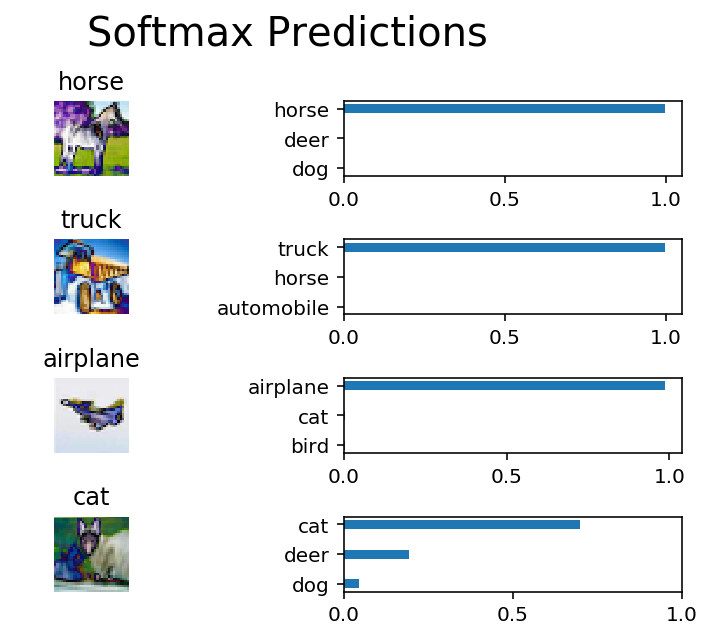

In [29]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()